## 7.4 VAEの実装

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

In [4]:
# ハイパーパラメータの設定
input_dim = 784 # 画像サイズ28x28=784
hidden_dim = 200 # 隠れ層の次元数
latent_dim = 20 # 潜在変数の次元数
epochs = 30
learning_rate = 3e-4
batch_size = 32

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.mu(x)
        logvar = self.logvar(x)
        sigma = torch.exp(logvar/2)
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
def reparametrize(mu, sigma):
    eps = torch.randn_like(sigma)
    return mu + sigma * eps

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparametrize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
        return (L1 + L2) / batch_size

In [8]:
# gpuを使う
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0
    cnt = 0

    for x, label in dataloader:
        x = x.to(device)
        loss = model.get_loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    losses.append(loss_sum / cnt)
    print(f'epoch: {epoch+1}, loss: {loss_sum / cnt}')

epoch: 1, loss: 53.83961737060547
epoch: 2, loss: 45.03522001749675
epoch: 3, loss: 43.01376819864909
epoch: 4, loss: 41.92591824747721
epoch: 5, loss: 41.23086577351888
epoch: 6, loss: 40.78212623494466
epoch: 7, loss: 40.50150243326823
epoch: 8, loss: 40.222634114583336
epoch: 9, loss: 40.07392986653646
epoch: 10, loss: 39.904839577229815
epoch: 11, loss: 39.738117814127605
epoch: 12, loss: 39.66098555908203
epoch: 13, loss: 39.563196327718096
epoch: 14, loss: 39.471194146728514
epoch: 15, loss: 39.41618465779622
epoch: 16, loss: 39.29239679158529
epoch: 17, loss: 39.22600565592448
epoch: 18, loss: 39.130588240559895
epoch: 19, loss: 39.08414747721354
epoch: 20, loss: 39.036880234781904
epoch: 21, loss: 38.984857253011064
epoch: 22, loss: 38.91090996500651
epoch: 23, loss: 38.85857709554036
epoch: 24, loss: 38.832796087646486
epoch: 25, loss: 38.76025887756348
epoch: 26, loss: 38.76449183959961
epoch: 27, loss: 38.7364746073405
epoch: 28, loss: 38.64777896830241
epoch: 29, loss: 38.5

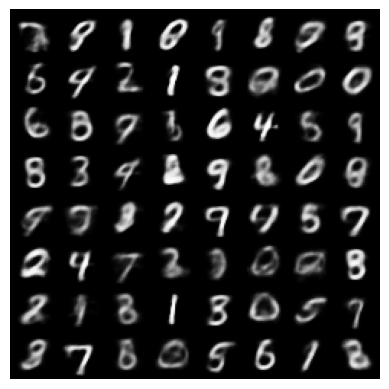

In [9]:
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    x_hat = model.decoder(z)
    x_hat = x_hat.view(-1, 1, 28, 28).cpu().numpy()

grid_img = torchvision.utils.make_grid(torch.tensor(x_hat), nrow=8, padding=2, normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()